In [1]:
%reload_ext autoreload

In [349]:
# Packages needed

#!pip install "tabulate" "pandas_summary" "imblearn" "joblib"
#!pip install fastai==0.7.0

In [357]:
# Imports

%load_ext autoreload
%autoreload 2

%matplotlib inline
import sys
import pandas as pd
from fastai.imports import *
from fastai.structured import *
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals import joblib

#import numpy as np
#import random
#from matplotlib import pyplot
#from pandas_summary import DataFrameSummary
#from IPython.display import display
#from tabulate import tabulate
#from sklearn.model_selection import GridSearchCV
#from scipy.stats.mstats import mode, gmean, hmean
#from sklearn import metrics

#set_plot_sizes(12,14,16)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [358]:
sys.path.append('../lib')
import utils
import preprocessing

In [359]:
# Load in data

PATH = "../data/"
df_raw = pd.read_csv(f'{PATH}churn.csv', low_memory=False, 
                     parse_dates=['canceldate', 'licence_registration_date', 'golive_date'])

In [360]:
print(len(df_raw), df_raw.shape)
df_processed = preprocessing.prepare_data(df_raw)
print(len(df_processed), df_processed.shape)

5889 (5889, 38)
5889 (5889, 100)


In [366]:
#df_filtered = df_processed[df_processed.licence_registration_Year >2016]
df_filtered = df_processed
print(len(df_processed), df_processed.shape)

5889 (5889, 100)


In [367]:
#df_processed['cases_age_hours_total_log'] = df_processed['cases_age_hours_total_log'].isna().fillna(df_processed['cases_age_hours_total_log'].mean())
#df_processed[df_processed['cases_age_hours_total_log'].isna() == True]
#df_processed[df_processed.isna() == True]

In [368]:
print(len(df_filtered[df_filtered.nps_detractor == 1]),len(df_filtered[df_filtered.nps_passive == 1]),len(df_filtered[df_filtered.nps_promoter == 1]))


5592 83 90


In [369]:
len(df_filtered[df_filtered.churned == 1]), len(df_filtered[df_filtered.churned == 0])

(3109, 2780)

In [365]:
print(len(df_filtered), df_filtered.shape)

5889 (5889, 100)


In [370]:
df_trn, y_trn, nas = proc_df(df_filtered, 'churned')
print(len(df_trn), df_trn.shape)

5889 (5889, 103)


In [371]:
#df_trn = df_trn.fillna(df_trn.mean())

df_trn[df_trn.username.isna() == True]
#df_trn.describe()

,username,merchant,team,vertical,salesperson,cases_total,cases_open,cases_closed,cases_age_hours_average,interactions_total,...,golive_Is_year_start,golive_Elapsed,days_active_log,golive_days_log,cases_age_hours_total_log,annual_revenue_log,churn_concern_cases_total_na,churn_concern_cases_open_na,total_churn_concern_cases_age_na,churn_concern_cases_avg_hours_na


In [372]:
def split_vals(a,n): return a[:n], a[n:]

n_valid = 500
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)

In [373]:
# Fix the dataset imbalance

#sm = SMOTE(random_state=12, ratio = 1.0)
#X_train_res, y_train_res = sm.fit_sample(X_train, y_train)
#X_train_res.shape
X_train.shape

(5389, 103)

In [374]:
len(df_filtered[df_filtered.churned == 1]), len(df_filtered[df_filtered.churned == 0])

(3109, 2780)

In [375]:
m = RandomForestClassifier(
    n_estimators=200,
    min_samples_leaf=2, 
    max_features='sqrt',
    n_jobs=-1, 
    #oob_score=True,
    max_depth=3,
    bootstrap=False,
    criterion='entropy',
    class_weight={0: 4, 1: 1}
    )

#m.fit(X_train_res, y_train_res)
m.fit(X_train, y_train)

y_pred = m.predict(X_valid)
print(utils.uber_score(y_valid, y_pred))
utils.conf_matrix(y_valid, y_pred)

# Save to file in the current working directory
joblib_file = "churn_model.pkl"
joblib.dump(m, joblib_file)

0.6578947368421053 0.30864197530864196 0.42016806722689076 0.862 0.35325434913017384 0.138
None
[[406  13]
 [ 56  25]]


['churn_model.pkl']

In [376]:
fi = rf_feat_importance(m, X_valid); fi[:10]

,cols,imp
9,interactions_total,0.158159
10,interactions_completed,0.139829
5,cases_total,0.093693
54,plan_PLAN-S-19Q1,0.085514
7,cases_closed,0.074690
6,cases_open,0.067974
52,plan_PLAN-S,0.046820
53,plan_PLAN-S-17Q2,0.043061
60,plan_STANDARD,0.037381
94,golive_Elapsed,0.029287


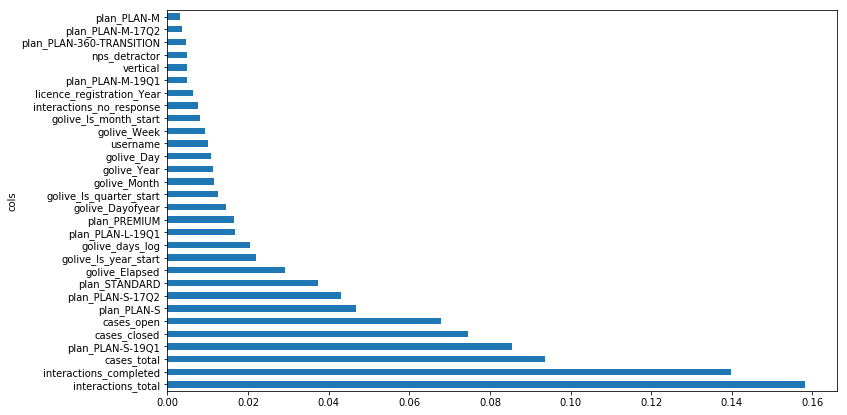

In [377]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)
plot_fi(fi[:30]);

In [329]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [330]:
m = RandomForestClassifier(
    n_estimators=200,
    min_samples_leaf=2, 
    max_features='sqrt',
    n_jobs=-1, 
    #oob_score=True,
    max_depth=3,
    bootstrap=False,
    criterion='entropy',
    class_weight={0: 4, 1: 1}
    )

m.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, class_weight={0: 4, 1: 1},
                       criterion='entropy', max_depth=3, max_features='sqrt',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=2,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=200, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

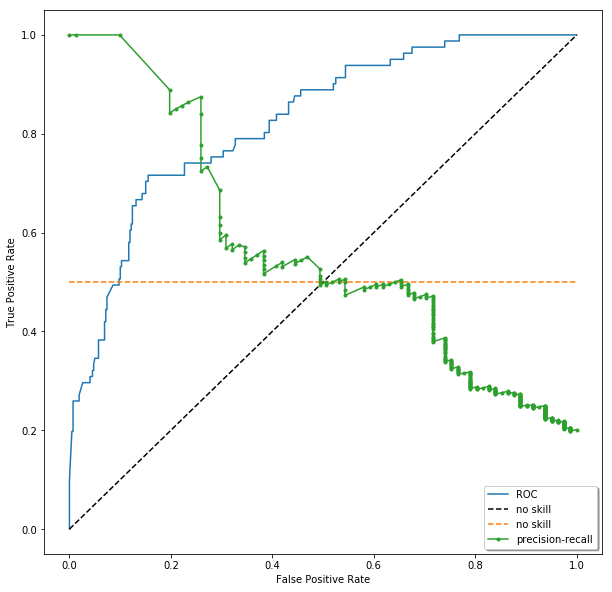

auc=0.567 ap=0.563


In [331]:
utils.plot_roc_pr(m, X_valid, y_valid)

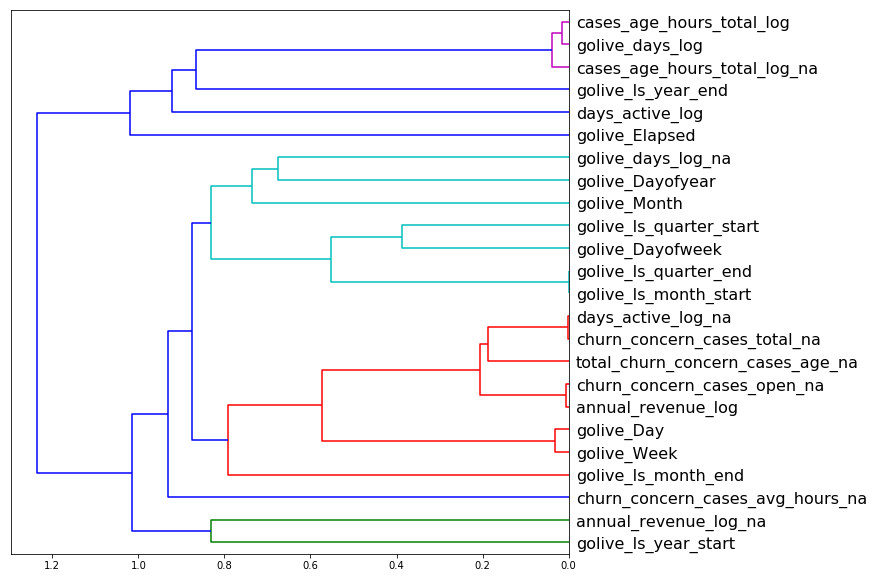

In [332]:
from scipy.cluster import hierarchy as hc
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(10,10))
dendrogram = hc.dendrogram(z, labels=df_trn.columns, orientation='left', leaf_font_size=16)
plt.show()

In [333]:
print("precision, recall, f1_score, accuracy, cohen_kappa_score, mean abs error")

for column in df_keep.columns:
    m = RandomForestClassifier(
        n_estimators=200,
        min_samples_leaf=2, 
        max_features='sqrt',
        n_jobs=-1, 
        max_depth=3,
        bootstrap=False,
        criterion='entropy',
        class_weight={0: 4, 1: 1}
        )

    x, _ = split_vals(df_keep.drop(columns=[column]), n_trn)
    m.fit(x, y_train)
    y_pred = m.predict(x)
    print(column, utils.uber_score(y_train, y_pred))

precision, recall, f1_score, accuracy, cohen_kappa_score, mean abs error
0.9830645161290322 0.8051519154557464 0.8852578068264342 0.8827240675449991 0.7677366171176614 0.11727593245500093
days_active_log None
0.9963133640552996 0.7140026420079261 0.8318584070796461 0.8378177769530525 0.6832665097654403 0.1621822230469475
interactions_completed None
0.996551724137931 0.6680977542932629 0.7999209173586398 0.8122100575245871 0.6355445732597998 0.1877899424754129
interactions_total None
0.996265172735761 0.7047556142668429 0.8255319148936171 0.8326220077936537 0.6735294587787184 0.16737799220634625
cases_total None
0.9926850258175559 0.761889035667107 0.8621076233183856 0.8630543700129895 0.730692025289644 0.13694562998701057
annual_revenue_log None
0.9971949509116409 0.7044253632760898 0.8256241532804336 0.832807570977918 0.6739352203072705 0.167192429022082
plan_PLAN-S-19Q1 None
0.9968036529680365 0.7209379128137384 0.8367190494442315 0.8419001670068659 0.6909619751066859 0.1580998329931